In [266]:
import random
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.optim import Adam
from torch.distributions import Categorical

import matplotlib.pyplot as plt
%matplotlib inline

from importlib import reload
import game
import dqn_agent
game = reload(game)
dqn_agent = reload(dqn_agent)
from game import Game
from dqn_agent import DQNAgent

import gym
# env = gym.make('CartPole-v0').unwrapped

In [267]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

In [268]:
moving_average = lambda x, **kw: pd.DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

In [269]:
class Policy(nn.Module):
    def __init__(self, state_size, act_size, hidden_size1, hidden_size2, hidden_size3):
      super(Policy, self).__init__()
      self.act = nn.Sequential(
                                nn.Linear(state_size, hidden_size1),
                                nn.ReLU(inplace=True),
                                nn.Linear(hidden_size1, hidden_size2),
                                nn.ReLU(inplace=True),
                                nn.Linear(hidden_size2, hidden_size3),
                                nn.ReLU(inplace=True),
                                nn.Linear(hidden_size3, act_size),
                                nn.Softmax(dim=-1)
                               )
        
    def forward(self, X):
      return self.act(X)
    
    def get_parameters(self):
       return self.state_dict()
    
    def set_parameters(self, state_dict):
        self.load_state_dict(state_dict)

In [270]:
state_size = 8
hidden_size1 = 256
hidden_size2 = 256
hidden_size3 = 256
act_size = 3


model = Policy(state_size, act_size, hidden_size1, hidden_size2, hidden_size3).to(device)

In [271]:
batch_size = 20
optimizer = Adam(model.parameters())
loss_func = nn.MSELoss()

dqn = DQNAgent(model, optimizer, loss_func, act_size, 5000, gamma=1.0)

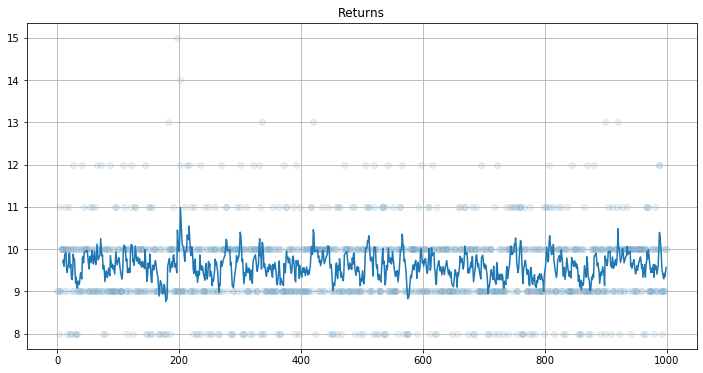

In [272]:
env = Game()
dqn.fit(env, 1000, batch_size)

In [273]:
def test_agent(env, agent=None, n_episodes=100):
    """Runs agent for n_episodes in environment and calclates mean reward.
    
    Args:
        env: The environment for agent to play in
        agent: The agent to play with. Defaults to None - 
            in this case random agent is used.
        n_episodes: Number of episodes to play. Defaults to 100.

    Returns:
        Mean reward for 100 episodes.
    """
    total_reward = []
    for episode in range(n_episodes):
        episode_reward = 0
        observation = env.reset()
        t = 0
        while True:
            if agent:
                with torch.no_grad():
                    probs = agent(torch.FloatTensor(observation).to(device))
                    dist = Categorical(probs)
                    action = dist.sample().item()
            else:
                action = random.randint(0, 2)
            observation, reward, done, _  = env.step(action)
            episode_reward += reward
            t += 1
            if done:
                print("Episode {} finished after {} timesteps".format(episode+1, t+1))
                break
        total_reward.append(episode_reward)
    # env.stop()
                   
    return np.mean(total_reward) 

In [274]:
# env = Game(drawing=True)
test_agent(env, agent=model, n_episodes=100)

Episode 1 finished after 10 timesteps
Episode 2 finished after 10 timesteps
Episode 3 finished after 9 timesteps
Episode 4 finished after 9 timesteps
Episode 5 finished after 11 timesteps
Episode 6 finished after 10 timesteps
Episode 7 finished after 10 timesteps
Episode 8 finished after 9 timesteps
Episode 9 finished after 11 timesteps
Episode 10 finished after 10 timesteps
Episode 11 finished after 10 timesteps
Episode 12 finished after 11 timesteps
Episode 13 finished after 12 timesteps
Episode 14 finished after 10 timesteps
Episode 15 finished after 10 timesteps
Episode 16 finished after 10 timesteps
Episode 17 finished after 10 timesteps
Episode 18 finished after 10 timesteps
Episode 19 finished after 11 timesteps
Episode 20 finished after 11 timesteps
Episode 21 finished after 10 timesteps
Episode 22 finished after 10 timesteps
Episode 23 finished after 11 timesteps
Episode 24 finished after 12 timesteps
Episode 25 finished after 11 timesteps
Episode 26 finished after 11 timestep

9.25